In [142]:
import numpy as np
import pandas as pd
import sys
import os
import re
import random
import nltk
import spacy
from sklearn.metrics import confusion_matrix
from spacy.util import minibatch
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier

# inicializácia mojich funkcií
sys.path.insert(1,cwd + '/brAIn_tools/')
import brAIn_Processor as bp

### Inicializácia premenných a objektov

In [40]:
cwd = os.getcwd()
nlp = spacy.blank("en")

# načítanie trainingdatasetu
dataset = pd.read_csv(cwd + '/Datasets/Spam/spam.csv.xls', encoding='cp437')

# zobrazenie prvých 3 riadkov
print(dataset.head(3))

# inicializácia TextCategorizer s vlastným nastavením a "bow" architektúrou
categorizer = nlp.create_pipe("textcat", 
                             config = {
                                 "exclussive_classes": True,
                                 "architecture": "bow"
                             })
# pridanie vlastného TextCategorizer do prázdneho modelu
nlp.add_pipe(categorizer)

# inicializácia labelov do klasifikátora
categorizer.add_label("ham")
categorizer.add_label("spam")

  category                                               text Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  


1

### Tréning modelu pre kategorizér

In [54]:
# inicializácia training setu viet z datasetu
train_text = dataset['text'].values
print(train_text.shape)

# inicializácia training labelov setu category
train_labels = [{'cats' : {'ham': label == 'ham',
                           'spam': label == 'spam'}}
               for label in dataset['category']]

# vytvorenie kombinovaného zoznamu textu a príslušnej kategórie
train_data = list(zip(train_text, train_labels))
#print(train_data[:3])

# rozdelenie datasetu na minibatche a poprípade aj zamiešanie training data
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()
random.seed(1)

# inicializácia premennej, ktorá bude zaznamenávať straty počas učenia
losses = {}

# nastavenie počtov epoch pre potreby lepšieho učenia
for epoch in range(10):
    # zamiešanie training data
    random.shuffle(train_data)
    
    # vytvorenie generátora mini batchov (v mojom prípade veľkosťou 8)
    batches = minibatch(train_data, size=8)
    # iterácia medzi minibatchmi
    for batch in batches:
        # každý batch obsahuje zoznam (text, label) ale pre správny update
        # musím prerozdeliť zoznam na texty a labely. Na to použijem zip
        # ktorý mi prerozdelý zoznam tuplov na zoznam objektov
        texts, labels = zip(*batch)
        nlp.update(texts, labels, sgd = optimizer, losses=losses)
    # vypísanie strát počas učenia
    print(losses)

(5572,)
{'textcat': 0.0839002572247125}
{'textcat': 0.13926357888274765}
{'textcat': 0.18399449728851636}
{'textcat': 0.22113989239486997}
{'textcat': 0.253858281191512}
{'textcat': 0.28316180248894973}
{'textcat': 0.3100417722000035}
{'textcat': 0.3350057540579545}
{'textcat': 0.35855912649300414}
{'textcat': 0.3808670160892813}


### Predikcia

In [50]:
# testovacie texty
texty = ["Are you ready for the tea party????? It's gonna be wild",
         "URGENT Reply to this message for GUARANTEED FREE TEA"]
# konverzia textu na dokumenty
docs = [nlp.tokenizer(text) for text in texty]

# využitie kategórii na získanie skóre predikcie
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict(docs)

# vypísanie skóre
print(scores)

# vypísanie najvyššieho skóre z predikcii pre každý z textov
predicted_labels = scores.argmax(axis=1)
print([textcat.labels[label] for label in predicted_labels])



[[0.99739385 0.00277646]
 [0.02088116 0.976437  ]]
['ham', 'spam']


### Porovnanie viacerých modelov

Accuracy score: 0.7865470852017937
Precision score: 0.3863013698630137
Recall score: 0.9096774193548387
F1 score: 0.5423076923076923
Accuracy score: 0.9632286995515695
Precision score: 0.9672131147540983
Recall score: 0.7612903225806451
F1 score: 0.8519855595667869
[0]


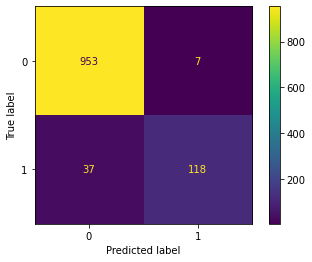

In [145]:
reviews = []
for row in train_text:  
    reviews.append(bp.preprocess(row).lower())  # lemmantizer, stemming, lower   
 
cv = CountVectorizer()
features = cv.fit_transform(reviews).toarray()
le = LabelEncoder()
labels = le.fit_transform(dataset['category'])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)



gnbClass = GaussianNB()
gnbClass.fit(X_train, y_train)
#prediction
gnbPrediction = gnbClass.predict(X_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, gnbPrediction)))
print('Precision score: {}'.format(precision_score(y_test, gnbPrediction)))
print('Recall score: {}'.format(recall_score(y_test, gnbPrediction)))
print('F1 score: {}'.format(f1_score(y_test, gnbPrediction)))


classifier1=RandomForestClassifier(n_estimators=10, max_features='auto', criterion='entropy')
classifier1.fit(X_train,y_train)
predRF=classifier1.predict(X_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, predRF)))
print('Precision score: {}'.format(precision_score(y_test, predRF)))
print('Recall score: {}'.format(recall_score(y_test, predRF)))
print('F1 score: {}'.format(f1_score(y_test, predRF)))

rfc=RandomForestClassifier(n_estimators=10, max_features='auto', criterion='entropy')
rfc.fit(X_train,y_train)
print(rfc.predict(cv.transform(["URGENT Reply to this message for GUARANTEED FREE TEA"])))

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

confusion_matrix(y_test, predRF)

plot_confusion_matrix(rfc, X_test, y_test)
plt.show()